# Day 3: Using Pandas Data Frames to analyze single cell electrophysiology data


<img src="http://www.zocalopublicsquare.org/wp-content/uploads/2016/12/Mathews-on-US-China.jpg" width="300" height="300" />

Today we will analyze patch-clamp data from a single PV+ neuron in a mouse cortical slice. The experiment was performed in current clamp. The experimenter injected 20 different square pulses of current and recorded the voltage response of the neuron to each pulse. Using the data from this experiment, we will create and F-I (frequency-current) curve.

## Outline of this notebook

[3.0 Import statements](#3.0-Import-statements)

[3.1 More on for-loops and if-else statements](#3.1-for-loops-and-if-else-statements) 
* A review on for-loops and if/else statements, and some new tricks for for-loops

[3.2 Load single cell electrophysiology data from csv file](#3.2-Load-single-cell-electrophysiology-data-from-.csv-file)
* Inspect data using pandas
* Visualize data with matplotlib

[3.3 Analyze a single sweep of electrophysiology data](#3.3-Analyze-a-single-sweep-of-electrophysiology-data)
* Calculate the firing rate of the neuron during a single sweep of data

[3.4 Create an F-I (frequency - current) curve](#3.4-Create-an-F-I-curve-for-a-single-cell)
* Write a function to calculate firing frequency during one sweep (3.4)
* Employ function in a for-loop to perform the operation for all sweeps

[3.5 Bonus exercises](#3.5-Bonus-exercises)
* Calculate the input resistance of a cell
* Extract spike cutouts
    * Create a phase plot for a spike (rate of change of voltage vs. voltage)
    
[3.6 Appendix](#Appendix)
* Additional information about loading binary file formats

# 3.0 Import statements

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.signal as ss

In [2]:
## Note: the following line is only needed inside the 
## Jupyter notebook, it is not a Python statement
%matplotlib inline

# 3.1 for-loops and if-else statements
Yesterday you learned how to use a for loop to iterate over the elements of a list (refer to section 2.7). Today we'll learn a couple additional tricks you can use when constructing for-loops.

Often we only want to perform an operation on the current element when a specific condition is met. For this, we use **if-else statements**. 

Though it's nice to loop over the elements in a list, sometimes we also would like the index where that element occurs. For this we can use the function **`enumerate()`**.

Let's create some dummy data in a Pandas `DataFrame` to illustrate these points:

In [3]:
# Let's use the numpy's rand() function to create an array of random floats with 
# shape (100,10)
data = np.random.rand(100,10)

# then create column names for the DataFrame
cols = ['one','two','three','four','five','six','seven','eight','nine','ten']    

# and convert our data into a DataFrame and cacluate indices
df = pd.DataFrame(columns = cols, index = np.arange(0,data.shape[0],1), data = data)
df.head(5)

,one,two,three,four,five,six,seven,eight,nine,ten
0,0.043063,0.037949,0.784281,0.976712,0.809022,0.922295,0.062343,0.125832,0.107583,0.520509
1,0.797026,0.285062,0.217050,0.735412,0.585679,0.850752,0.511171,0.689018,0.237387,0.970731
2,0.585250,0.726878,0.162991,0.492518,0.039468,0.883434,0.038273,0.073107,0.198404,0.545605
3,0.432278,0.162295,0.638587,0.219611,0.799499,0.347351,0.773142,0.219750,0.546086,0.058879
4,0.003209,0.352095,0.840439,0.052429,0.748747,0.767842,0.190492,0.039773,0.908644,0.857148


### Exercise 1 - Review from day 2
> * Refer to section 2.7 from yesterday to write a for loop that loops over all the column names in `df` and prints them out.

In [36]:
# list of all column names in the df above
cols = df.columns 

# Your loop goes here
for col in cols:
    print(col)

one
two
three
four
five
six
seven
eight
nine
ten


Sometimes, we want to have access not only to the elements of cols ('one', 'two' etc.), but also to the correspondings indexes for these elements (0, 1, 2 etc.). We can achieve this by using a built-in function [enumerate()](http://book.pythontips.com/en/latest/enumerate.html).

One example of why this might be useful is if you only want to perform an operation on the columns of **odd** indexes. With only the column name, we can't do this. Using a combination of the indexes and if-else statements (refer to section 1.14 of Day 1).

In [5]:
for i, col in enumerate(cols):
    if (i+1)%2 == 0: # notice that i starts counting from 0, so we must add 1
        pass # tells python to skip this if-else statement and move on to the next iteration in the loop
    else:
        print(i)
        print(col)

0
one
2
three
4
five
6
seven
8
nine


### Exercise 2

>* Use what you just learned about for-loops to write a loop that prints out only the names of the even numbered columns.

In [8]:
# Your code goes here
for i, col in enumerate(cols):
    if (i+1)%2!=0:
        pass
    else:
        print(col)

two
four
six
eight
ten


Yesterday you also learned a little bit about how to write your own functions. Below is an illustration of how functions, loops, and if-else statements can be combined in a useful way. We will use these concepts later so make sure you have a good grasp on the code below.

In [10]:
def print_even_or_odd_column(dataframe, cols='even'):   # note that the default value of columns is even
    
    columns=dataframe.columns
    
    # code to be executed if you tell the function to print even columns
    if cols=='even':
        for i, col in enumerate(columns):
            if (i+1)%2==0:
                print(col)
            else:
                pass
            
    # code to be executed if you tell the function to print off columns        
    elif cols=='odd':
        for i, col in enumerate(columns):
            if (i+1)%2!=0:
                print(col)
            else:
                pass


# ==== Call the function ====
print_even_or_odd_column(df,cols='even')   # can set cols to be 'odd' or 'even'

two
four
six
eight
ten


# 3.2 Load single cell electrophysiology data from .csv file

**Set file path to day-2 of the python_neurobootcamp (concepts from Day 2 - section 2.1)**

In [11]:
#print "Current Working Directory (cwd)" to check we're in the righ place (don't need absolute path)
os.getcwd()

'/home/charlie/Desktop'

In [12]:
path = 'csv_data/'

#### The data:

As those of you who do patch clamp know, e-phys data doesn't come nicely packaged into a simple spreadhsheet format. Therefore, we have written a function that converts axon binary files (.abf) into spreadheet format (.csv) for the purposes of this course. 

If you are interested in exactly how this process works, look into the file: `binary_file_loading_tools.py` in the `day-3` directory or see Appendix section at the bottom of this notebook. It's a little bit rough, but will help give you an idea of how you can convert binary files to spreadsheets. After completing this course, you should be able to modify this file on your own to suit your needs.

A note on csv files: CSV = Comma-Separated Value file that stores tabular data (numbers and text) in plain text. You can save an excel spreadsheet in .csv and then import it in Python. Let's look at an example. (open up csv file from the day-3/csv_data folder in excel)

**Load spreadsheet data into pandas**

Note the use of `index_col=0`. Try to get rid of this and see what happens when you load based on default settings. For more information: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [13]:
meta = pd.read_csv("csv_data/meta_data_PV_3_10_03_2014.csv", index_col=0)
data = pd.read_csv("csv_data/data_PV_3_10_03_2014.csv",index_col=0)

In [14]:
meta.head()

,fs,celltype,date,ch1_units,ch2_units
sweep1,100000.0,PV,10_03_2014,mV,pA
sweep2,100000.0,PV,10_03_2014,mV,pA
sweep3,100000.0,PV,10_03_2014,mV,pA
sweep4,100000.0,PV,10_03_2014,mV,pA
sweep5,100000.0,PV,10_03_2014,mV,pA


Notice that in our meta data, we have information about the sampling rate (fs), cell type, date of recording, units for ch1 data, and units for ch2 data for each sweep in the binary file that we loaded. This information will become particulalrly useful for analyses in which, for example, we want to group anlayses by cell type.

In [15]:
data.head()

,ch1_sweep1,ch2_sweep1,ch1_sweep2,ch2_sweep2,ch1_sweep3,ch2_sweep3,ch1_sweep4,ch2_sweep4,ch1_sweep5,ch2_sweep5,...,ch1_sweep16,ch2_sweep16,ch1_sweep17,ch2_sweep17,ch1_sweep18,ch2_sweep18,ch1_sweep19,ch2_sweep19,ch1_sweep20,ch2_sweep20
0.00000,-48.889160,0.0,-49.652100,0.0,-49.224854,0.0,-48.675537,0.0,-48.187256,0.0,...,-51.330566,0.0,-52.947998,0.0,-55.236816,0.0,-52.856445,0.0,-53.619385,0.0
0.00001,-49.011230,0.0,-49.926758,0.0,-49.194336,0.0,-48.583984,0.0,-47.912598,0.0,...,-51.300049,0.0,-52.947998,0.0,-55.206299,0.0,-52.917480,0.0,-53.466797,0.0
0.00002,-49.072266,0.0,-49.743652,0.0,-49.255371,0.0,-48.400879,0.0,-47.882080,0.0,...,-51.086426,0.0,-52.856445,0.0,-55.023193,0.0,-53.100586,0.0,-53.833008,0.0
0.00003,-48.980713,0.0,-49.682617,0.0,-49.163818,0.0,-48.492432,0.0,-48.095703,0.0,...,-50.994873,0.0,-52.917480,0.0,-55.023193,0.0,-52.917480,0.0,-53.833008,0.0
0.00004,-49.041748,0.0,-49.774170,0.0,-49.041748,0.0,-48.553467,0.0,-48.065186,0.0,...,-51.422119,0.0,-53.100586,0.0,-55.358887,0.0,-52.886963,0.0,-53.619385,0.0


Though the channels aren't labeled, we can determine what each represents by the their units (pico-amps or milli-volts in this case) which we can get above (in meta data).

Notice that data contains the time series for each channel on each sweep. The indexes here represent the time points that each value was acquired at.

In [16]:
meta.shape

(20, 5)

In [17]:
data.shape

(100000, 40)

### Visualization using matplotlib and seaborn

We learned a bit about seaborn yesterday. Matplotlib is another widely used plotting library in Python. Everyone has their own preference for which they like to use. Here we will go through examples of each, though we will focus on matplotlib. You can decide for yourself which you prefer. 

Before we get into analysis, it's always a good idea to inspect your raw data to make sure you know what's there, and that it was loaded properly.

First let's use Pandas built-in `filter()` function to assign all ch1 traces to a `DataFrame` called `voltage_traces` and all ch2 traces to a `DataFrame` called `current_traces`. For basics of filtering, refer back to section 2.9.

Here we use regular expressions to filter the data. These can be very confusing at first, but don't worry. Regular expression are very powerful and worth spending some time getting used to. For more information: https://docs.python.org/2/library/re.html

In [18]:
voltage_traces = data.filter(regex="ch1.", axis=1) # to filter on rows instead of columns, use axis=0
current_traces = data.filter(regex="ch2.",axis=1)

In [19]:
## Set the index name
voltage_traces.index.name = 'Time'
current_traces.index.name = 'Time'

In [20]:
voltage_traces.head()

,ch1_sweep1,ch1_sweep2,ch1_sweep3,ch1_sweep4,ch1_sweep5,ch1_sweep6,ch1_sweep7,ch1_sweep8,ch1_sweep9,ch1_sweep10,ch1_sweep11,ch1_sweep12,ch1_sweep13,ch1_sweep14,ch1_sweep15,ch1_sweep16,ch1_sweep17,ch1_sweep18,ch1_sweep19,ch1_sweep20
Time,,,,,,,,,,,,,,,,,,,,
0.00000,-48.889160,-49.652100,-49.224854,-48.675537,-48.187256,-48.248291,-48.522949,-48.065186,-49.072266,-47.729492,-47.729492,-48.919678,-48.858643,-49.163818,-51.025391,-51.330566,-52.947998,-55.236816,-52.856445,-53.619385
0.00001,-49.011230,-49.926758,-49.194336,-48.583984,-47.912598,-47.973633,-48.461914,-48.095703,-48.767090,-47.851562,-47.790527,-48.828125,-48.736572,-48.980713,-51.147461,-51.300049,-52.947998,-55.206299,-52.917480,-53.466797
0.00002,-49.072266,-49.743652,-49.255371,-48.400879,-47.882080,-48.034668,-48.065186,-48.400879,-48.553467,-47.760010,-47.973633,-48.706055,-48.645020,-49.224854,-51.391602,-51.086426,-52.856445,-55.023193,-53.100586,-53.833008
0.00003,-48.980713,-49.682617,-49.163818,-48.492432,-48.095703,-48.187256,-48.187256,-48.400879,-48.828125,-47.515869,-47.912598,-49.072266,-49.072266,-49.224854,-51.239014,-50.994873,-52.917480,-55.023193,-52.917480,-53.833008
0.00004,-49.041748,-49.774170,-49.041748,-48.553467,-48.065186,-48.095703,-48.400879,-48.095703,-49.011230,-47.698975,-47.760010,-48.980713,-48.980713,-49.011230,-51.086426,-51.422119,-53.100586,-55.358887,-52.886963,-53.619385


### Plot using matplotlib

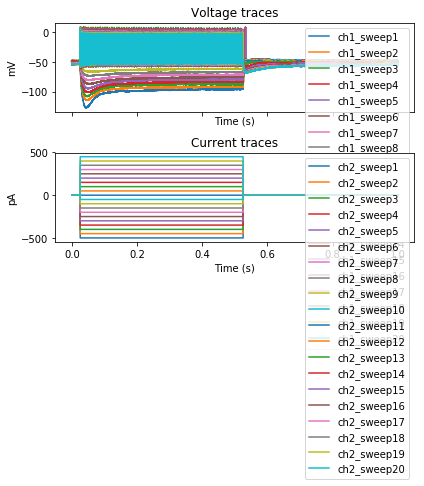

In [21]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(voltage_traces)
ax[0].legend(voltage_traces,loc='upper right')
ax[0].set_title('Voltage traces')
ax[0].set_ylabel(meta['ch1_units'][0])
ax[0].set_xlabel('Time (s)')

ax[1].plot(current_traces)
ax[1].legend(current_traces,loc='upper right')
ax[1].set_title('Current traces')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel(meta['ch2_units'][0])

plt.tight_layout()
plt.show()

### Plot using Pandas
Pandas offers wrapper functions around matplotlib that make the above code a bit more concise. We'll use this (plotting with Pandas) quite a bit in this notebook. 

Just note that what it's really doing is written out explicity above. See [here](https://pandas.pydata.org/pandas-docs/stable/visualization.html) for a little more explanation.

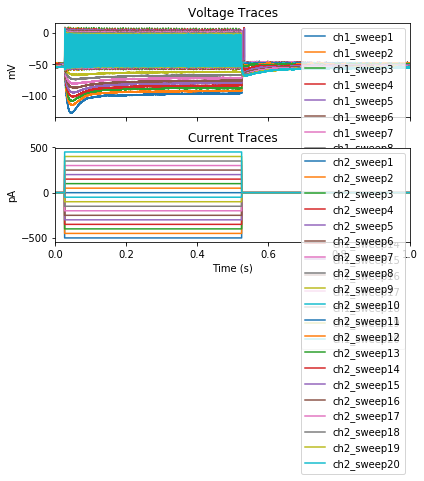

In [22]:
fig, ax = plt.subplots(2,1,sharex=True)
voltage_traces.plot(title='Voltage Traces', ax=ax[0])    # calling plot (a matplotlib wrapper from pandas)
current_traces.plot(title='Current Traces', ax=ax[1])
## Position the legends
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
## Set X and Y axis labels
ax[0].set(ylabel=meta['ch1_units'][0])
ax[1].set(ylabel=meta['ch2_units'][0], xlabel='Time (s)')
plt.tight_layout();

### Plot using seaborn
Note that there are some slight tweaks you need to make to the data in this case in order to use seaborn, including downsampling the data (otherwise it takes A LONG time to run). Mostly for this reason, we'll stick with using matplotlib for the rest of today. Just be aware that you can also use seaborn if you prefer.

Reformat (melt) the data into "long form" from "wide from". This is a step that will be necessary with any data in wideform that you want to plot in this way.

In [23]:
## Reformat the dataframe to work with a Seaborn time-series plot
voltage_ts = voltage_traces.iloc[:,:5].copy()
voltage_ts['Time'] = voltage_ts.index
voltage_ts = pd.melt(voltage_ts, id_vars='Time', var_name='Sweep', value_name='mV')
voltage_ts['Dummy'] = 0

Downsample the data so that this runs faster. This is quirk for this type of data that is sampled at a very high sampling rate making seaborn run rather slowly.

In [24]:
## Downsample the data (take every 50th row)
voltage_ts = voltage_ts.iloc[np.arange(500000)[::50],:]
voltage_ts.head()

,Time,Sweep,mV,Dummy
0,0.0000,ch1_sweep1,-48.889160,0
50,0.0005,ch1_sweep1,-49.041748,0
100,0.0010,ch1_sweep1,-49.011230,0
150,0.0015,ch1_sweep1,-49.102783,0
200,0.0020,ch1_sweep1,-49.194336,0


Perform the same operations on the current trace data.

In [25]:
## Do the same for the current traces
## Reformat the dataframe to work with a Seaborn time-series plot
current_ts = current_traces.iloc[:,:5].copy()
current_ts['Time'] = current_ts.index
current_ts = pd.melt(current_ts, id_vars='Time', var_name='Sweep', value_name='pA')
current_ts['Dummy'] = 0
## Downsample the data (take every 50th row)
current_ts = current_ts.iloc[np.arange(500000)[::50],:]

Now, plot the data using the seaborn function `tsplot` [time-series plot](http://seaborn.pydata.org/generated/seaborn.tsplot.html).

Note in particular the argument "unit". We must pass it something otherwise seaborn will run into issues when it tries to calculate confidence intervals for this data. Therefore we just pass a "Dummy" unit to make seaborn happy since we don't really care about the confidence interval in this case.

/home/charlie/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


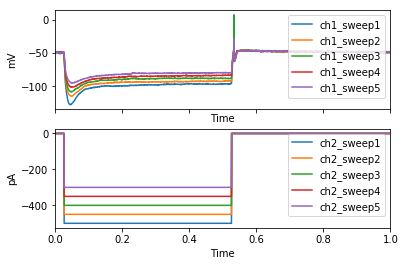

In [26]:
# This will take a minute to load
fig, ax = plt.subplots(2,1,sharex=True)
sns.tsplot(data=voltage_ts, time='Time', condition='Sweep', unit='Dummy', value='mV', err_style=None, ax=ax[0])
sns.tsplot(data=current_ts, time='Time', condition='Sweep', unit='Dummy', value='pA', err_style=None, ax=ax[1])
# Position the legends
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right');

This is pretty messy. Can we make it better?

### Exercise 3

>* Try plotting only the last sweep of both current and voltage so that we can see what's going on more easily.
* Use the code from above as a starting point for how to create your own plot. Ask a TA or instructor if you need help.

First, let's find the column id for the last sweep using the "tricks" above (there are multiple ways to do this).

As you might remember from Day-1, we can use "-1" to grab the last index of something. This is equivalent to using "end" in Matlab.

In [27]:
lastSweep_voltage = voltage_traces.columns[-1]     
lastSweep_current = current_traces.columns[-1]

print(lastSweep_voltage)
print(lastSweep_current)

ch1_sweep20
ch2_sweep20


Now, use these  column id's to select only the columns containing data for the last sweep:

In [29]:
last_voltage = voltage_traces[lastSweep_voltage]
last_current = current_traces[lastSweep_current]

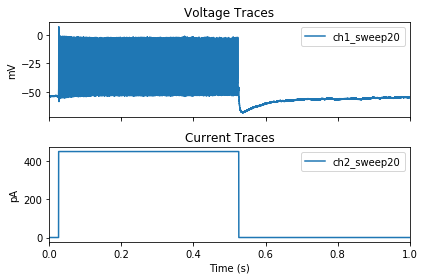

In [33]:
## Plot with Pandas
## Create a figure and plot first 5 voltage and current traces
fig, ax = plt.subplots(2,1,sharex=True)
last_voltage.plot(title='Voltage Traces', ax=ax[0])
last_current.plot(title='Current Traces', ax=ax[1])

## Position the legends
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

## Set X and Y axis labels
ax[0].set(ylabel=meta['ch1_units'][0])
ax[1].set(ylabel=meta['ch2_units'][0], xlabel='Time (s)')
plt.tight_layout();

That looks better, but can we zoom in on some of the spikes in the voltage traces?

### Exercise 4
>* Plot only time points from 0.02 to 0.10 seconds:

In [37]:
# define the range of indexes you want to select
inds = data.index[(0.02 < data.index) & (data.index < 0.1)]

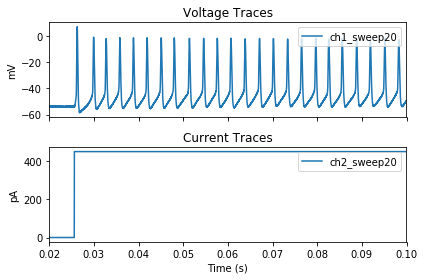

In [35]:
## Plot with Pandas
## Create a figure and plot first 5 voltage and current traces
fig, ax = plt.subplots(2,1,sharex=True)
last_voltage[inds].plot(title='Voltage Traces', ax=ax[0])
last_current[inds].plot(title='Current Traces', ax=ax[1])
## Position the legends
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
## Set X and Y axis labels
ax[0].set(ylabel=meta['ch1_units'][0])
ax[1].set(ylabel=meta['ch2_units'][0], xlabel='Time (s)')
plt.tight_layout();

# 3.3 Analyze a single sweep of electrophysiology data

A common way to show a neuron's response to input is to make a frequency-intensity curve (F-I curve).  The frequency of firing is plotted on the y-axis and the amplitude of the current injection that caused the spikes is plotted on the x-axis.  

From looking at these F-I curves you can identify if the cell is transiently firing, whether the spike rate reaches a maximum at some high current step, the gain of firing (the slope of the line, in Hz/pA), etc.  To construct a F-I curve we need to first find the number of spikes per unit time in each sweep and the current injection that drove those spikes. Then plot it.

First, we will perform the analysis for just one sweep of data. Then, if there is time, we will define a function to help automate the process. We will run the function on all sweeps using a for-loop, and plot the results in a F-I curve.  

Becasue we have already pulled out the last voltage trace, let's go ahead and analyze this time-series first.

The analysis will consist of a few key steps:
* Step 1: Locate the time points of all spikes
* Step 2: Find the time window and magnitude of current injection
* Step 3: Calculate the firing rate

### Step 1: Locate the time points of all spikes
* There are a couple of ways to do this. We will do it by locating the relative maxima of the voltage trace during the current injection
* We will also set a threshold above which to detect maxima (to avoid counting local maxima in the baseline (noise) as a spikes)

In [78]:
threshold = -20  
last_voltage_thresholded = last_voltage[last_voltage > threshold]  

Let's take a look at what happened when we thresholded the voltage trace:

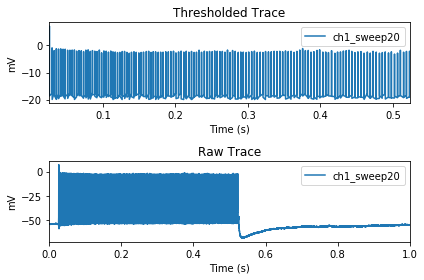

In [79]:
## Plot with Pandas
## Create a figure and plot first 5 voltage and current traces
## Note: X-axis is different for each subplot
fig, ax = plt.subplots(2,1)
last_voltage_thresholded.plot(title='Thresholded Trace', ax=ax[0])
last_voltage.plot(title='Raw Trace', ax=ax[1])

## Position the legends
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

## Set X and Y axis labels
ax[0].set(ylabel=meta['ch1_units'][0], xlabel='Time (s)')
ax[1].set(ylabel=meta['ch1_units'][0], xlabel='Time (s)')
plt.tight_layout();

Using a a threshold of -20, we have selected all the voltage points above -20 mV. In other words, these are all points during which an action potential was happening.

*Scipy*, another useful Python package, has a function that finds the indices where relative extrema occur: `argrelextrema`
This function takes two required arguments: data and comparator (for details see [documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.argrelextrema.html)).

* Note: `last_voltage_thresholded` is a Pandas DataFrame. `argrelextrema` expects data to be an Array, not a DataFrame.
* Note: `argrelextrema` also takes an optional argument: "order" that specifies the amount of points on each size to use for the comparison.

In [80]:
indexes_of_maxima = ss.argrelextrema(data=last_voltage_thresholded.values, comparator=np.greater, order=1)

The Scipy function returns indexes, *i.e.* 1,2 3... BUT we want the time points (which are stored in the index of our DataFrame)

In [81]:
spike_times = last_voltage_thresholded.index[indexes_of_maxima] 

It's possible that the voltage trace is a little noisy, even during a spike. This might cause a spike to be double counted by the Scipy function, which is only locating relative/local maxima. To fix these cases, we impose a constraint based on the refractory period of neuron.

In [82]:
refractory_period_low_limit = 0.002  # 2ms is a lower limit on the refracotry period for a neuron

Now, let's calculate the interspike intervals for all the maxima we located (using numpy's ediff1d function) and exclude any spikes that violate the refractory period.
* np.ediff1d: Calculates the difference between all adjancent elements in a 1d array: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ediff1d.html
* np.arghwere: Locates the indexes where the given condition is met: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argwhere.html

In [83]:
interspike_interval = np.ediff1d(spike_times)

Remove the refractory period violations

In [84]:
VIOLATION_indexes = np.argwhere(interspike_interval<refractory_period_low_limit)
spike_times = spike_times.delete(VIOLATION_indexes)
print(spike_times)

Float64Index([0.0262702627026,  0.029940299403, 0.0327403274033,
              0.0358303583036, 0.0388803888039, 0.0419104191042,
              0.0450904509045, 0.0480104801048, 0.0513905139051,
              0.0545705457055,
              ...
               0.481364813648,  0.485284852849,  0.489334893349,
               0.493844938449,   0.49779497795,   0.50214502145,
               0.506355063551,  0.510245102451,  0.514685146851,
               0.522875228752],
             dtype='float64', name='Time', length=134)


We now have an array of time points where we think spikes occured. Let's plot them to see if we were successful

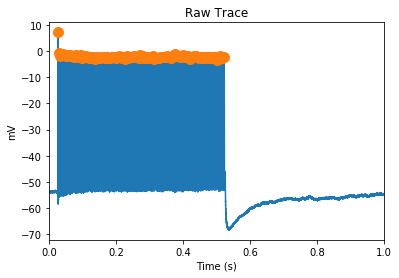

In [85]:
## Plot with Pandas
ax = last_voltage.plot(title='Raw Trace')
ax.set(ylabel=meta['ch1_units'][0], xlabel='Time (s)')
ax.plot(spike_times, last_voltage[spike_times], ".", markersize=20); # plot a point at each time point where a spike was detected

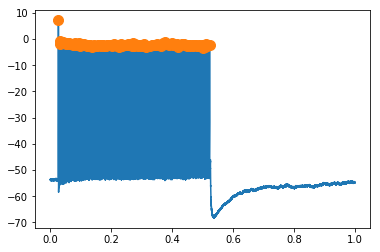

In [86]:
# plot with matplotlib
plt.figure()
plt.plot(last_voltage)
plt.plot(spike_times, last_voltage[spike_times], ".", markersize=20) # plot a point at each time point where a spike was detected

This is looking pretty good. 

### Exercise 5
>* What happens if you now change the threshold to -60 and re-run the cells above? This should help illustrate why it's important to choose the apporpriate threshold when detecting spikes.

Now, let's zoom in on some spikes to make sure we really are counting each individual spike

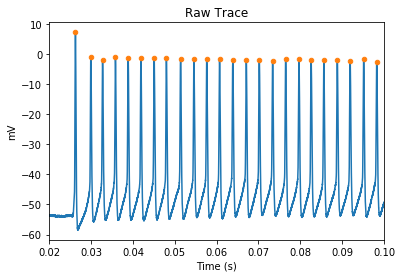

In [87]:
## Plot with Pandas
ax = last_voltage[inds].plot(title='Raw Trace')
ax.set(ylabel=meta['ch1_units'][0], xlabel='Time (s)')
ax.plot(last_voltage[inds][spike_times], ".", markersize=9); # plot a point at each time point where a spike was detected

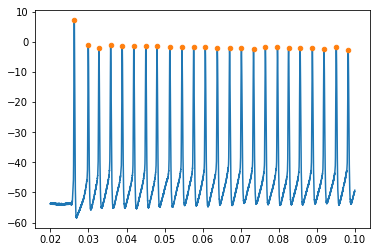

In [88]:
# Plot with matplotlib
plt.figure()
plt.plot(last_voltage[inds])
plt.plot(last_voltage[inds][spike_times],".",markersize=9)
plt.show()

Great, looks like we are capturing all the spikes, not double counting, and not counting any noise as spikes. 

### Step 2: Find out the time window of current injection
This is pretty straightforward for this experiment because as we saw earlier, it's just square pulse injections. Therefore, we can just find the time points where `current == max(current`.

In [89]:
current_magnitude = max(last_current.values)  
current_inj_times = last_current.index[last_current==current_magnitude] # time points when current is being injected   
current_inj_length = max(current_inj_times) - min(current_inj_times) # duration in seconds
print("Current injection: "+str(current_magnitude)+" pA")
print(["Current injection times:", current_inj_times])
print('Current injection length: '+str(current_inj_length)+" s")

Current injection: 450.0 pA
['Current injection times:', Float64Index([0.0256202562026, 0.0256302563026, 0.0256402564026,
              0.0256502565026, 0.0256602566026, 0.0256702567026,
              0.0256802568026, 0.0256902569026, 0.0257002570026,
              0.0257102571026,
              ...
               0.525525255253,  0.525535255353,  0.525545255453,
               0.525555255553,  0.525565255653,  0.525575255753,
               0.525585255853,  0.525595255953,  0.525605256053,
               0.525615256153],
             dtype='float64', name='Time', length=50000)]
Current injection length: 0.49999499995 s


Before we calculate the firing frequecny, there is one last check we must perform. It is possile that some spontaneous spikes occured outside the current injection window (it didn't happen in this case, but it could and that could change our results). To handle this, we remove all spikes times outside of the current injection window. To do this, we create a boolean mask (list of `True` and `False`) which we can then use to only grab indixes where there is a one:

In [90]:
boolean_array = (max(current_inj_times)>= spike_times) & (spike_times >= min(current_inj_times)) # boolean array (0's and 1's)
print(boolean_array)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


Now, use the boolean mask to get only the spike times inside the appropriate time window

In [91]:
spike_times = spike_times[boolean_array]   # only saving spike times where boolean_array=True e.g. during current injection

### Step 3: Calculate the firing rate 
There are couple of different ways to calculate firing frequency. They are both useful and tell you different things.  
The most straighforward way is to simply count the number of spikes and divide by the amout of time (in seconds) that the current was being injected.

In [92]:
n_spikes = len(spike_times)
spike_freq = n_spikes/current_inj_length

print("spiking frequency = " + str(round(spike_freq,2))+" Hz")

spiking frequency = 268.0 Hz


The second way to go about this is to calculate the average interspike interval. This is particularly useful if the neuron does not continue to fire or adapts during the current injection.

In [93]:
ISI = np.ediff1d(spike_times) #interspike interval
meanISI = np.mean(ISI)  # calculate the mean ISI
spike_freq = 1/meanISI  # ISI is in units of seconds, divide 1s/meanISI to get mean firing frequency
print("spiking frequency = " +str(round(spike_freq,2))+"Hz")

spiking frequency = 267.82Hz


For this cell, both methods give us basially the same result because as we saw above, this neuron fires pretty regularly during the entire stimulation. This isn't necesarily the case, so it's good to check. 

One final check we can perform is just to look at all the raw ISI values to make sure there wasn't a change in frequency over the course of the stimulation (high firing at the beginnning, slower at the end)

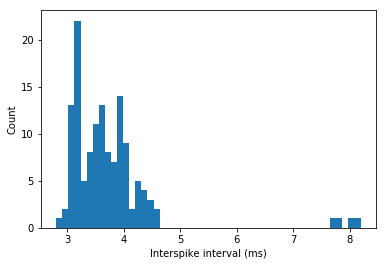

In [94]:
plt.figure()
plt.hist(ISI*1000,bins=50) # convert to ms by multiplying by 1000
plt.ylabel('Count')
plt.xlabel('Interspike interval (ms)');

This looks pretty good with the exception of a few outliers. It also confirms that there are no refractory period violations. 


### Exercise 6
* Go back and re-run everything from "Step 1" but this time, DO NOT run the cells that corrected for refractory period violations. This should illustrate why this final histogram can be a good check on your analysis.

####  Summary of single sweep analysis 
Although what we really want is the F-I curve for the cell, analyzing one sweep at a time, like we did here, is often a good idea. This way, you can make sure that the code you write is really analyzing the data in the way you intend.

# 3.4 Create an F-I curve for a single cell

To do this, we will perform the above analysis many times. Once for each current injection/sweep. 

Because we are doing the same thing many times, rather than write all of the above code 20 times (once for each sweep), we'll write a "for" loop that performs the same operation many times

When you are performing an operation many times, it is often nice to write function to perform this operation. We will write a function that returns the firing frequency for any sweep.

**Let's write a function that returns the firing rate for a single sweep of data:**

In [95]:
def get_firing_rate(v, threshold, tstart, tend, method="ISI"):
    '''
    ================ This is called a doc string ====================
    ========== It tells you how to use the function =================
    ======= It is what is printed when you call "help" ==============
    Arguments:
        v (data frame): array of voltage values during one sweep with the index being the time series
        threshold (float): cut-off to count spikes
        tstart (float): time current injection begins
        tend (float): time current injection ends
        method (string, optional): method for calculating the firing rate
                ISI: use interspike interval
                AVG: use average over whole current injection window
    Output:
        firing_rate (float): firing rate during the period defined by tstart and tend
    '''
    refractory_limit=0.002 # set refractory period limit (to avoid double counting spikes)
    current_duration = tend-tstart
    
    v_thresh = v[v>threshold]
    
    spike_indexes = ss.argrelextrema(v_thresh.values, np.greater,order=1)  # indices of spikes (0,1,2...)
    spike_times = v_thresh.index[spike_indexes]  # convert to time (in seconds)   
    
    # get rid of refractory violations
    interspike_interval = np.ediff1d(spike_times)
    VIOLATION_indexes = np.argwhere(interspike_interval<refractory_limit)
    spike_times = spike_times.delete(VIOLATION_indexes)    # delete any spike times that occured too soon after a previous spike
    
    # get rid of spikes outside the current injection window
    tf = (tend >= spike_times) & (spike_times >= tstart) # boolean array (0's and 1's)
    spike_times = spike_times[tf]   # only saving spike times where tf==1 e.g. during current injection
    
    if method=="ISI":
        # calculate the firing frequency using interspike interval
        # in case there were no spikes, set firing rate to 0 Hz
        if spike_times.size==0:
            firing_rate=0  # there were no spikes, so firing rate is 0
        else:
            ISI = np.mean(np.ediff1d(spike_times))
            firing_rate = 1/ISI
    elif method=="AVG":
        firing_rate = len(spike_times)/current_duration
    
    return firing_rate

There is alot going on in that function. If you are confused on any part of it, please ask the instructor or TAs for assitance. 
* You should understand how the function works, and how to modify it if you need/want to
* You should understand the difference between required and optional function arguments
* You should understand the if-else statements at the end of the function definition

Note: check out what happens when you call "help" on the function we just wrote:

In [96]:
help(get_firing_rate)

Help on function get_firing_rate in module __main__:

get_firing_rate(v, threshold, tstart, tend, method='ISI')
    ================ This is called a doc string ====================
    ========== It tells you how to use the function =================
    ======= It is what is printed when you call "help" ==============
    Arguments:
        v (data frame): array of voltage values during one sweep with the index being the time series
        threshold (float): cut-off to count spikes
        tstart (float): time current injection begins
        tend (float): time current injection ends
        method (string, optional): method for calculating the firing rate
                ISI: use interspike interval
                AVG: use average over whole current injection window
    Output:
        firing_rate (float): firing rate during the period defined by tstart and tend



**Write a for-loop to calculate the firing rate for every sweep of data**

First, let's intitalize the constants that we will use throughout the analysis
    * threshold
    * current_duration

In [97]:
# set threshold above which to detect spikes
threshold = -20   

# Find current duration (same for all sweeps so we can just do this once)
current_magnitude = max(last_current.values)  
current_inj_times = last_current.index[last_current==current_magnitude] # time points when current is being injected  
I_start = min(current_inj_times)
I_end = max(current_inj_times)
current_duration = max(current_inj_times) - min(current_inj_times) # duration in seconds   

Loop over all the sweeps, find the current magnitude and firing rate, print them out

Define the list of sweeps to loop over:

In [98]:
sweeps = meta.index

In [99]:
for i, sweep in enumerate(sweeps):
    
    # Call our function that we wrote above (get_firing_rate)    
    firing_rate = get_firing_rate(data['ch1_'+sweep], threshold, I_start, I_end, method="ISI")  
    
    # get current injection magnitude
    # Note how we deal with negative current injections using if-else statements
    I_mag = max(data['ch2_'+sweep])
    if I_mag == 0 and min(data['ch2_'+sweep])==0:
        I_mag = 0
    elif I_mag == 0 and min(data['ch2_'+sweep]) != 0:
        I_mag = min(data['ch2_'+sweep])
    
    # print the result
    print(sweep+":  "+"I: "+str(I_mag)+" "+meta['ch2_units'][i]+ ",   Firing rate: "+str(firing_rate)+" Hz")

sweep1:  I: -500.0 pA,   Firing rate: 0 Hz
sweep2:  I: -450.0 pA,   Firing rate: 0 Hz
sweep3:  I: -400.0 pA,   Firing rate: 0 Hz
sweep4:  I: -350.0 pA,   Firing rate: 0 Hz
sweep5:  I: -300.0 pA,   Firing rate: 0 Hz
sweep6:  I: -250.0 pA,   Firing rate: 0 Hz
sweep7:  I: -200.0 pA,   Firing rate: 0 Hz
sweep8:  I: -150.0 pA,   Firing rate: 0 Hz
sweep9:  I: -100.0 pA,   Firing rate: 0 Hz
sweep10:  I: -50.0 pA,   Firing rate: 0 Hz
sweep11:  I: 0 pA,   Firing rate: 0 Hz
sweep12:  I: 50.0 pA,   Firing rate: 91.3232876712 Hz
sweep13:  I: 100.0 pA,   Firing rate: 118.079399011 Hz
sweep14:  I: 150.0 pA,   Firing rate: 145.729830385 Hz
sweep15:  I: 200.0 pA,   Firing rate: 166.198832543 Hz
sweep16:  I: 250.0 pA,   Firing rate: 185.082744885 Hz
sweep17:  I: 300.0 pA,   Firing rate: 206.924963838 Hz
sweep18:  I: 350.0 pA,   Firing rate: 223.973223834 Hz
sweep19:  I: 400.0 pA,   Firing rate: 243.008495341 Hz
sweep20:  I: 450.0 pA,   Firing rate: 267.81850584 Hz


There's a lot of stuff going on here as well. Some key takeaways:
* Make sure you understand the for loop, what it's doing, and why it's useful
* Make sure that the if-else statements inside the for loop are making sense
* If you are confused on these points, ask the instructor or a TA

Now that we understand how the code above is working, let's run it again but this time actually save the results instead of just printing them out. To save our results, let's create a new data frame called "results" to store everything.

In [100]:
results = pd.DataFrame(columns=["Current Injection", "Firing Rate"],index = meta.index)
results.head()

,Current Injection,Firing Rate
sweep1,NaN,NaN
sweep2,NaN,NaN
sweep3,NaN,NaN
sweep4,NaN,NaN
sweep5,NaN,NaN


We've now created an empty data frame to store the results for all data sweeps. Using a for loop, let's again calculate the current injection and firing rate for each sweep and fill up the empty results DataFrame.

In [101]:
for i, sweep in enumerate(sweeps):
    firing_rate = get_firing_rate(data['ch1_'+sweep],threshold,I_start,I_end,method="ISI")
    
    I_mag = max(data['ch2_'+sweep])
    if I_mag == 0 and min(data['ch2_'+sweep])==0:
        I_mag = 0
    elif I_mag == 0 and min(data['ch2_'+sweep]) != 0:
        I_mag = min(data['ch2_'+sweep])
       
    results['Current Injection'][sweep]=I_mag
    results['Firing Rate'][sweep]=firing_rate

Now, we have stored all our results into a new data frame.

In [102]:
results

,Current Injection,Firing Rate
sweep1,-500,0
sweep2,-450,0
sweep3,-400,0
sweep4,-350,0
sweep5,-300,0
sweep6,-250,0
sweep7,-200,0
sweep8,-150,0
sweep9,-100,0
sweep10,-50,0


Now, we can create our f-i plot for this neuron

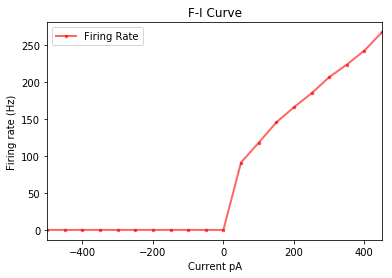

In [103]:
## Plot with Pandas
ax = results.plot('Current Injection', 'Firing Rate', title='F-I Curve', marker=".", color="r", lw=2, markersize=5, alpha=0.6)
ax.set(xlabel='Current '+meta['ch2_units'][0], ylabel='Firing rate (Hz)');

Cool, we now have an F-I curve for this PV neuron. 

### Final Excercise: do the same analysis but calculate frequency as n_spikes/time instead of using the ISI as we just did
> * Add the result to the DataFrame called `results` and name this new column `"Firing rate (avg)"`
**Hint**: one way to add a column to a DataFrame is to make a series and then add it to the original DataFrame
    * newcolumn = pd.series(index=, name=)
    * pd.concat((results,newcolumn),axis=1)
* Once you've accomplished all this, plot the results alongside the trace above

[More on how to create  new column using Pandas series](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html)

In [109]:
newColumn = pd.Series(index=sweeps, name="Firing Rate (avg)")

Now loop over all the data and fill in the new column.

In [110]:
for i, sweep in enumerate(sweeps):
    
    firing_rate = get_firing_rate(data['ch1_'+sweep],threshold,I_start,I_end, method="AVG")
    
    newColumn[sweep]=firing_rate


Concatenate `newColumn` with results
Check out [this](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html) for help.

In [111]:
results = pd.concat((results,newColumn),axis=1)
results


,Current Injection,Firing Rate,0,0,Firing Rate (avg)
sweep1,-500,0,0.00000,0.00000,0.00000
sweep2,-450,0,0.00000,0.00000,0.00000
sweep3,-400,0,0.00000,0.00000,0.00000
sweep4,-350,0,0.00000,0.00000,0.00000
sweep5,-300,0,0.00000,0.00000,0.00000
sweep6,-250,0,0.00000,0.00000,0.00000
sweep7,-200,0,0.00000,0.00000,0.00000
sweep8,-150,0,0.00000,0.00000,0.00000
sweep9,-100,0,0.00000,0.00000,0.00000
sweep10,-50,0,0.00000,0.00000,0.00000


Plot the results for both methods on the same figure.

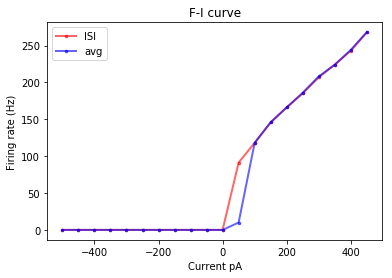

In [112]:
# Use examples of plotting from above
plt.figure()
plt.plot(results['Current Injection'].values, results['Firing Rate'].values, ".-", color="r", lw=2,
         markersize=5, alpha=0.6)
plt.plot(results['Current Injection'].values, results['Firing Rate (avg)'].values, ".-", color="b", lw=2,
         markersize=5, alpha=0.6)
plt.xlabel('Current '+meta['ch2_units'][0])
plt.ylabel('Firing rate (Hz)')
plt.legend(['ISI', 'avg'])
plt.title('F-I curve')
plt.show()


Basically, we get the same result. However, we do see a clear difference for the first positive current step, when the cell did not continue to fire over the course of the current injection but only fired a burst of spikes at the beginning of stimulation

# 3.5 Bonus exercises

### 1. Calculate the input resistance of the cell (Easier)

Recall Ohm's law: voltage = current * resistance (V=IR). We know the current and we know the voltage so we can solve for R, the cell's input resistance. Using ohms law and the hints below, solve for this cell's input resistance.

* Hint 1: Input resistance is a passive property of a neuron, therefore we'll have to measure it when voltage activated channels are not opening/closing. Remember from our analysis above, there were a bunch of negative current steps that elicited no action potentials.

* Hint 2: Even though the negative current steps didn't cause action potentials to fire there could still have been some channels opened, changing the resistance of the cell (for example, Ih currents). Therefore, it's probably best to use voltage measurements when the cell was in a steady state (later on in the current injection).

* Hint 3: Ohms law is a linear relationship. In other words, if we plot voltage vs. current we should see a straight line (if no channels were opening and closing). The slope of this line is R. Plot voltage vs. current for all negative current injections and meausre the slope at the point where the line is most linear.

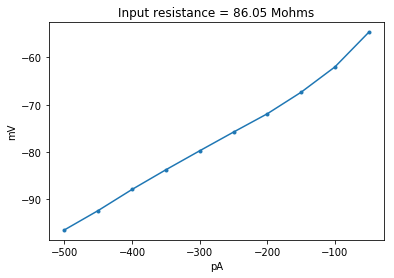

In [113]:
# ==============================   Solution    ========================================

negative_current_sweeps = results.index[[i for i in results['Current Injection']<0]]
tstart=0.4
tend=0.5
steady_state_voltage = []
current=[]
for sweep in negative_current_sweeps:
    steady_state_voltage.append(np.mean(data['ch1_'+sweep][tstart:tend]))
    current.append(results['Current Injection'][sweep])

plt.figure()
plt.plot(current, steady_state_voltage,'.-')
plt.ylabel('mV')
plt.xlabel('pA')


# remove last two current injections because seems to get non-linear there
# and convert to Volts and Amps
R = ((steady_state_voltage[-2]-steady_state_voltage[0])/1000)/((current[-2] - current[0])/10e12)
R_mohms = round(R/10e6,2)
plt.title('Input resistance = ' + str(R_mohms)+ ' Mohms')

plt.show()

### 2. Create a phase-plot for this cell (More difficult)
A phase plot is a plot of voltage vs. the derivative of the voltage (rate of change) during an action potential. Here's an example:
<img src = 'phase_plot.png'>

Your goal is to create a phase plot for the action potentials fired during the 500pA current injection. There a few steps involved to do this:
* Step 1: Generate and array of "spike cutouts" during this current step. In other words, make a 2D numpy array where the rows are time points and the columns are individual action potentials. Do this by taking 1ms of data before an AP peak and 2ms of data after a peak. Hint: remember how we found the time points of AP peaks earlier...

* Step 2: Generate an equivalent numpy array except in this array, each column is the derivative of the action potential in the array from step 1

* Step 3: Take the mean of all columns in both arrays and then plot action potential mean on the x-axis vs. the derivative mean on the y-axis

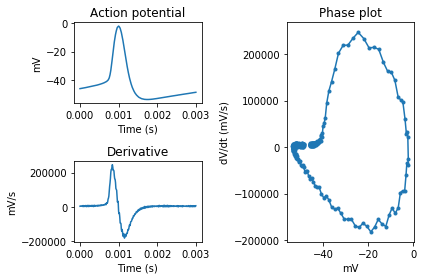

In [114]:
# ============================== Solution =======================================

# get the voltage values for the 500pA sweep (last sweep)

voltages = voltage_traces[voltage_traces.columns[-1]]

# find spike times
threshold=-20
voltages_thresh = voltages[voltages>-20]
indexes_of_maxima = ss.argrelextrema(data=voltages_thresh.values, comparator=np.greater, order=1)
spike_times = voltages_thresh.index[indexes_of_maxima]

# get rid of refractory violations
interspike_interval = np.ediff1d(spike_times)
VIOLATION_indexes = np.argwhere(interspike_interval<0.002)
spike_times = spike_times.delete(VIOLATION_indexes)

# get spike cutouts
n_spikes = len(spike_times)
len_spike_window = len(voltages[0:0.003])

# make an empty arrays to hold spike cutouts and derivatives
spike_cutouts = np.empty((n_spikes,len_spike_window-1))
derivative = np.empty((n_spikes, len_spike_window-2))

# fill arrays
fs = meta['fs'][0]
for i in range(0, n_spikes):
    spike_cutouts[i,:] = voltages[(spike_times[i]-0.001):(spike_times[i]+0.002)].squeeze()
    derivative[i,:] = np.ediff1d(spike_cutouts[i,:])/(1/fs)

spike = np.mean(spike_cutouts,axis=0)[:-1]
deriv = np.mean(derivative,axis=0)

plt.figure()
time = np.linspace(0,0.003,len(spike))
plt.subplot(221)
plt.title('Action potential')
plt.plot(time,spike)
plt.xlabel('Time (s)')
plt.ylabel('mV')

plt.subplot(223)
plt.title('Derivative')
plt.xlabel('Time (s)')
plt.ylabel('mV/s')
plt.plot(time,deriv)

plt.subplot(122)
plt.title('Phase plot')
plt.ylabel('dV/dt (mV/s)')
plt.xlabel('mV')
plt.plot(spike, deriv,'.-')
plt.tight_layout()

plt.show()

# 3.6 Appendix

### Loading binary files (.abf, .dat, etc.) using the python package, neo

*neo* is an open source python package, like numpy or pandas. It was written specifically to help load binary file formats from electrophysiology data into python. We have written a function that uses this package to load .abf files into a .csv data format (spreadsheet). If you are interested in learning more about this, ask one of your TA's or intsructors, or just go look at the file binary_file_loading_tools.py that is located in the day 3 folder. Note, in order to run the loading function, you will need neo installed on your machine. To do this, type: "pip install neo" into a terminal window on your machine. For more information on neo, see: http://neuralensemble.org/neo/
 